# CuAI NLP Workshop #1 (based on Stanford)
<!-- ### <font color='blue'> Due 3:15pm, Tue Jan 11 </font> -->

Welcome to the CuAI NLP Workshop on word vectors, tokenisation and embedding. 

The format of the notebook is some incomplete code, which you then implement and can then run tests on to ensure it works. By the end of the notebook, you will have implemented `word2vec`, a neural net-based approach to generating word vectors, which will build skills generalizable to building more powerful language models next workshop (this Saturday).

---
<details>
<summary>Some more resources:</summary>

Some exercises will require using `numpy` arrays. These are arrays on which computations run much faster than lists. You can often just think of these as lists and take the syntax you need from a reference like the good one <a href="https://cs231n.github.io/python-numpy-tutorial/#numpy">here</a>.

If you want more background on `numpy`, read about broadcasting <a href="https://numpy.org/doc/stable/user/basics.broadcasting.html">here</a>. Broadcasting is the biggest thing different for numpy arrays and lists. It's also exactly what is done in PyTorch and hence almost all current ML models in order to parallelize operations and train models in days not years.
</details>

---

*See the license here: https://see.stanford.edu/UsingSEE*.

# Setup 

If you are familiar with mounting your drive in colab, we'd recommend you do this since files will be persistent, but this is not necessary.

In [ ]:
import os 
from google.colab import drive

ROOT_DIR = "/content/drive/"
DRIVE_DIR = "MyDrive/"
MOUNT_FOLDER = input("Enter the folder to save work in Drive: ") # "ML-exported/ML/CuAINLP1"
if MOUNT_FOLDER[-1] == "/":
    MOUNT_FOLDER = MOUNT_FOLDER[:-1]
FULL_DIR = ROOT_DIR+DRIVE_DIR+MOUNT_FOLDER
CORPORA_DIRECTORY = f"{FULL_DIR}/corpora"

if "drive" not in os.getcwd(): # hopefully prevents multiple runs breaking things
    drive.mount(ROOT_DIR, force_remount=True)

import os 
if not os.path.exists(FULL_DIR):
    os.mkdir(FULL_DIR)

%cd $FULL_DIR

In [ ]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the assignment 1: https://web.stanford.edu/class/cs224n/index.html#schedule. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters', download_dir=FULL_DIR) 

from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

In [ ]:
# this takes two minutes - be patient

import zipfile

if not os.path.exists(f"{CORPORA_DIRECTORY}/reuters"): # again hopefully stops multiruns
    with zipfile.ZipFile(f"{CORPORA_DIRECTORY}/reuters.zip", 'r') as zip_ref:
        zip_ref.extractall(CORPORA_DIRECTORY)

# Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-occurrence with Fixed Window of $n=1$**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In this case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

**Point of confusion:** each word in a text does have two vectors (column and row) associated with it in a co-occurrence matrix, but these are too large to be practically used as word vectors - we will blackbox ;) (so no need to understand) *(Truncated) Singular Value Decomposition* from linear algebra to reduce the dimension.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "grain" (i.e. news articles about corn, wheat, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [ ]:
def read_corpus(category="grain"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [ ]:
nltk.data.path.append(FULL_DIR)
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

### Question 1.1: Implement `distinct_words` [code]

Write a method to work out the distinct words (word types) that occur in the corpus. 

---
<details>
<summary>Some advice</summary>
You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.
</details>

---

In [ ]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents

        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    # ------------------
    # Write your implementation here.

    # ------------------

    return corpus_words, n_corpus_words

In [ ]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

### Question 1.2: Implement `compute_co_occurrence_matrix` [code]

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    
    

    # ------------------

    return M, word2ind

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

### Question 1.3: Implement `reduce_to_k_dim` [code]

The rows (or columns) of the co-occurrence matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](https://i.imgur.com/q1XjR9Q.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

---
<details>
<summary>Further details on SVD</summary>
**Notes:** If you can barely remember what an eigenvalue is, here's <a href = "https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf">a slow, friendly introduction to SVD</a>. If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures 7, 8 and 9 of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD">Truncated SVD</a> — then there are reasonably scalable techniques to compute those iteratively.

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
</details>

---

If you'd like to go through the sklearn library in order to make TruncatedSVD work on your own go ahead, though if you're not interested feel free to move fast and copy the solution into the code cell below

---
<details>
<summary>SPOILERS! Solution to truncated SVD from library functions</summary>

```
svd = TruncatedSVD(n_components=k, n_iter=10)
svd.fit(M)
M_reduced = svd.components_.T
```

</details>

In [ ]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.

    # ------------------

    print("Done.")
    return M_reduced

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

### Question 1.4: Implement `plot_embeddings` [code]

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [ ]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


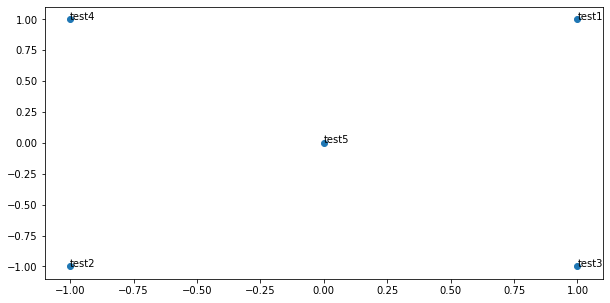

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>

<details>
<summary>See what the plot should look like</summary>
<img src="https://i.imgur.com/gvnNQi0.png" width=40% style="float: left;"> </img>
</details>

### Question 1.5: Co-Occurrence Plot Analysis [code and exploration]

Now you will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "grain" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. 

---
<details>
<summary>More details on SVD for the curious</summary>
TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).
</details>

---

Use your `plot_embeddings` function in order to plot some of the embeddings from the grain corpus. The code in the first cell below that runs the SVD for you will be useful. You might also want to revisit the cell above that printed out the first few texts in the corpus to get inspiration for words to visualise.

It's worth spending some time interpreting what our model is doing, so we'd recommend finding at least 3 words that are similar and are close in embedding, and also a pair of words that are similar but aren't close in the embedding.

<details>
<summary>Hint</summary>
Use the `word2ind_co_occurrence` variable as a parameter to `plot_embeddings`
<!-- plot_embeddings(M_normalized, word2ind_co_occurrence, words) -->
</details>

In [ ]:
# -----------------------------
# Run SVD on the corpus
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

# ---------------
# Write your implementation here (use plot_embeddings)



# ---------------

## Part 2: Prediction-Based Word Vectors

More recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    # print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [ ]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index2word)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis

Copy over your code from above to plot the 2D GloVe embeddings for words that you found embeddings for from co-occurrence, making sure that you use the new word2ind conversion, and the new embeddings.

Find at least one way in which these embeddings are similar and one way in which they're different from the `word2ind` embeddings.

In [ ]:
# ---------------
# Write your implementation here (use the previous plot_embeddings implementation)

# ---------------

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="https://i.imgur.com/FLnGMJm.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + exploration] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

State the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [ ]:
# ------------------
# Write your implementation here.



# ------------------

### Question 2.3: Synonyms & Antonyms [code + exploration] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [ ]:
# ------------------
# Write your implementation here.


# ------------------

### Question 2.4: Analogies with Word Vectors [answer]
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [ ]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the answer, respectively. Using **only** vectors $m$, $g$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `grandfather` and the answer?

### Question 2.5: Finding Analogies [code + exploration]
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [ ]:
# ------------------
# Write your implementation here.



# ------------------

### Question 2.6: Incorrect Analogy [code + exploration]
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [ ]:
# ------------------
# Write your implementation here.



# ------------------

### Question 2.7: Guided Analysis of Bias in Word Vectors [exploration]

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "girl" and "toy" and most dissimilar to "boy", and (b) which terms are most similar to "boy" and "toy" and most dissimilar to "girl". Point out the difference between the list of female-associated words and the list of male-associated words, and see how it is reflecting gender bias.

In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + exploration]

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
# ------------------
# Write your implementation here.


# ------------------

### Question 2.9: Thinking About Bias [exploration] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias? Is there a way that this bias could be removed, perhaps in our 'training' process of generating embeddings?

## `word2vec` implementation

We will now refer to the word2vec algorithm as described [here](http://web.stanford.edu/class/cs224n/assignments/a2.pdf), and a good guide to the algorithm (much more diagram- than maths-heavy) can be found [here](https://jalammar.github.io/illustrated-word2vec/).

The first bunch of cells setup the tests, no editing is needed:

### Setup

Ignore the following cell, it defines all helper functions and tests that we will later use

In [ ]:
def normalizeRows(x):
    """ Row normalization function

    Implement a function that normalizes each row of a matrix to have
    unit length.
    """
    N = x.shape[0]
    x /= np.sqrt(np.sum(x**2, axis=1)).reshape((N,1)) + 1e-30
    return x

def getDummyObjects():
    """ Helper method for naiveSoftmaxLossAndGradient and negSamplingLossAndGradient tests """

    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0,4)], \
            [tokens[random.randint(0,4)] for i in range(2*C)]

    dataset = type('dummy', (), {})()
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10,3))
    dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])

    return dataset, dummy_vectors, dummy_tokens

def test_sigmoid():
    """ Test sigmoid function """
    print("=== Sanity check for sigmoid ===")
    assert sigmoid(0) == 0.5
    assert np.allclose(sigmoid(np.array([0])), np.array([0.5]))
    assert np.allclose(sigmoid(np.array([1,2,3])), np.array([0.73105858, 0.88079708, 0.95257413]))
    print("Tests for sigmoid passed!")

def softmax(x):
    """Compute the softmax function for each row of the input x.
    It is crucial that this function is optimized for speed because
    it will be used frequently in later code. 

    Arguments:
    x -- A D dimensional vector or N x D dimensional numpy matrix.
    Return:
    x -- You are allowed to modify x in-place
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        tmp = np.max(x, axis=1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis=1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        # Vector
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp
      
    assert x.shape == orig_shape
    return x
  
def gradcheck_naive(f, x, gradientText):
    """ Gradient check for a function f.
    Arguments:
    f -- a function that takes a single argument and outputs the
         loss and its gradients
    x -- the point (numpy array) to check the gradient at
    gradientText -- a string detailing some context about the gradient computation

    Notes:
    Note that gradient checking is a sanity test that only checks whether the
    gradient and loss values produced by your implementation are consistent with
    each other. Gradient check passing on its own doesn’t guarantee that you
    have the correct gradients. It will pass, for example, if both the loss and
    gradient values produced by your implementation are 0s (as is the case when
    you have not implemented anything). Here is a detailed explanation of what
    gradient check is doing if you would like some further clarification:
    http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/. 
    """
    rndstate = random.getstate()
    random.setstate(rndstate)
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4        # Do not change this!

    # Iterate over all indexes ix in x to check the gradient.
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        x[ix] += h # increment by h
        random.setstate(rndstate)
        fxh, _ = f(x) # evalute f(x + h)
        x[ix] -= 2 * h # restore to previous value (very important!)
        random.setstate(rndstate)
        fxnh, _ = f(x)
        x[ix] += h
        numgrad = (fxh - fxnh) / 2 / h

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print("Gradient check failed for %s." % gradientText)
            print("First gradient error found at index %s in the vector of gradients" % str(ix))
            print("Your gradient: %f \t Numerical gradient: %f" % (
                grad[ix], numgrad))
            return

        it.iternext() # Step to next dimension

    print("Gradient check passed!. Read the docstring of the `gradcheck_naive`"
    " method in utils.gradcheck.py to understand what the gradient check does.")

def test_naiveSoftmaxLossAndGradient():
    """ Test naiveSoftmaxLossAndGradient """
    dataset, dummy_vectors, dummy_tokens = getDummyObjects()

    print("==== Gradient check for naiveSoftmaxLossAndGradient ====")
    def temp(vec):
        loss, gradCenterVec, gradOutsideVecs = naiveSoftmaxLossAndGradient(vec, 1, dummy_vectors, dataset)
        return loss, gradCenterVec
    gradcheck_naive(temp, np.random.randn(3), "naiveSoftmaxLossAndGradient gradCenterVec")

    centerVec = np.random.randn(3)
    def temp(vec):
        loss, gradCenterVec, gradOutsideVecs = naiveSoftmaxLossAndGradient(centerVec, 1, vec, dataset)
        return loss, gradOutsideVecs
    gradcheck_naive(temp, dummy_vectors, "naiveSoftmaxLossAndGradient gradOutsideVecs")

def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2),:]
    outsideVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

def test_word2vec():
    """ Test the two word2vec implementations, before running on Stanford Sentiment Treebank """
    dataset = type('dummy', (), {})()

    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0, 4)], \
            [tokens[random.randint(0, 4)] for i in range(2*C)]
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10, 3))
    dummy_tokens = dict([("a", 0), ("b", 1), ("c", 2), ("d", 3), ("e", 4)])

    print("==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, naiveSoftmaxLossAndGradient),
        dummy_vectors, "naiveSoftmaxLossAndGradient Gradient")

    print("==== Gradient check for skip-gram with negSamplingLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, negSamplingLossAndGradient),
        dummy_vectors, "negSamplingLossAndGradient Gradient")

    print("\n=== Results ===")
    print("Skip-Gram with naiveSoftmaxLossAndGradient")

    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\nGradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 3, ["a", "b", "e", "d", "b", "c"],
                  dummy_tokens, dummy_vectors[:5, :], dummy_vectors[5:, :], dataset)
    )
    )

    print("Expected Result: Value should approximate these:")
    print("""Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]
    """)

    print("Skip-Gram with negSamplingLossAndGradient")
    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\n Gradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5, :],
                  dummy_vectors[5:, :], dataset, negSamplingLossAndGradient)
    )
    )
    print("Expected Result: Value should approximate these:")
    print("""Loss: 16.15119285363322
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-4.54650789 -1.85942252  0.76397441]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
 Gradient wrt Outside Vectors (dJ/dU):
 [[-0.69148188  0.31730185  2.41364029]
 [-0.22716495  0.10423969  0.79292674]
 [-0.45528438  0.20891737  1.58918512]
 [-0.31602611  0.14501561  1.10309954]
 [-0.80620296  0.36994417  2.81407799]]
    """)

import os.path as op
import numpy as np
import random
import glob
import pickle
SAVE_PARAMS_EVERY = 5000


def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)

def sanity_check():
    def quad(x): return (np.sum(x ** 2), x * 2)

    print("Running sanity checks...")
    t1 = sgd(quad, 0.5, 0.01, 1000, PRINT_EVERY=100)
    print("test 1 result:", t1)
    assert abs(t1) <= 1e-6

    t2 = sgd(quad, 0.0, 0.01, 1000, PRINT_EVERY=100)
    print("test 2 result:", t2)
    assert abs(t2) <= 1e-6

    t3 = sgd(quad, -1.5, 0.01, 1000, PRINT_EVERY=100)
    print("test 3 result:", t3)
    assert abs(t3) <= 1e-6

    print("-" * 40)
    print("ALL TESTS PASSED")
    print("-" * 40)

### Implement $\sigma$

In [ ]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    Arguments:
    x -- A scalar or numpy array.
    Return:
    s -- sigmoid(x)
    """

    ### YOUR CODE HERE (~1 Line)

    ### END YOUR CODE

    return s

test_sigmoid()

## Implement softmax loss and gradients



In [ ]:
def naiveSoftmaxLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset
):
    """ Naive Softmax loss & gradient function for word2vec models

    Implement the naive softmax loss and gradients between a center word's 
    embedding and an outside word's embedding. This will be the building block
    for our word2vec models. For those unfamiliar with numpy notation, note 
    that a numpy ndarray with a shape of (x, ) is a one-dimensional array, which
    you can effectively treat as a vector with length x.

    Arguments:
    centerWordVec -- numpy ndarray, center word's embedding
                    in shape (word vector length, )
                    (v_c in the pdf handout)
    outsideWordIdx -- integer, the index of the outside word
                    (o of u_o in the pdf handout)
    outsideVectors -- outside vectors is
                    in shape (num words in vocab, word vector length) 
                    for all words in vocab (tranpose of U in the pdf handout)
    dataset -- needed for negative sampling, unused here.

    Return:
    loss -- naive softmax loss
    gradCenterVec -- the gradient with respect to the center word vector
                     in shape (word vector length, )
                     (dJ / dv_c in the pdf handout)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    in shape (num words in vocab, word vector length) 
                    (dJ / dU)
    """

    ### YOUR CODE HERE (~6-8 Lines)

    ### Please use the provided softmax function (imported earlier in this file)
    ### This numerically stable implementation helps you avoid issues pertaining
    ### to integer overflow. 

    

    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs
  
test_naiveSoftmaxLossAndGradient()

## Implement Negative Sampling Loss and Gradient, as well as Skipgram

[note tests require both of these to be implemented]

In [ ]:
def negSamplingLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset,
    K=10
):
    """ Negative sampling loss function for word2vec models

    Implement the negative sampling loss and gradients for a centerWordVec
    and a outsideWordIdx word vector as a building block for word2vec
    models. K is the number of negative samples to take.

    Note: The same word may be negatively sampled multiple times. For
    example if an outside word is sampled twice, you shall have to
    double count the gradient with respect to this word. Thrice if
    it was sampled three times, and so forth.

    Arguments/Return Specifications: same as naiveSoftmaxLossAndGradient
    """

    # Negative sampling of words is done for you. Do not modify this if you
    # wish to match the autograder and receive points!
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices

    ### YOUR CODE HERE (~10 Lines)
    ### Please use your implementation of sigmoid in here.


    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs

    return loss, gradCenterVec, gradOutsideVecs


def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    """ Skip-gram model in word2vec

    Implement the skip-gram model in this function.

    Arguments:
    currentCenterWord -- a string of the current center word
    windowSize -- integer, context window size
    outsideWords -- list of no more than 2*windowSize strings, the outside words
    word2Ind -- a dictionary that maps words to their indices in
              the word vector list
    centerWordVectors -- center word vectors (as rows) is in shape 
                        (num words in vocab, word vector length) 
                        for all words in vocab (V in pdf handout)
    outsideVectors -- outside vectors is in shape 
                        (num words in vocab, word vector length) 
                        for all words in vocab (transpose of U in the pdf handout)
    word2vecLossAndGradient -- the loss and gradient function for
                               a prediction vector given the outsideWordIdx
                               word vectors, could be one of the two
                               loss functions you implemented above.

    Return:
    loss -- the loss function value for the skip-gram model
            (J in the pdf handout)
    gradCenterVec -- the gradient with respect to the center word vector
                     in shape (num words in vocab, word vector length)
                     (dJ / dv_c in the pdf handout)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    in shape (num words in vocab, word vector length) 
                    (dJ / dU)
    """

    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    ### YOUR CODE HERE (~8 Lines)
    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    # YOUR CODE HERE

    ### END YOUR CODE
    
    return loss, gradCenterVecs, gradOutsideVectors

test_word2vec()

### Implement SGD for training

In [ ]:
def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=10):
    """ Stochastic Gradient Descent
    Implement the stochastic gradient descent method in this function.
    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss
    Return:
    x -- the parameter value after SGD finishes
    """

    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        def postprocessing(x): return x

    exploss = None

    for iter in range(start_iter + 1, iterations + 1):
        # You might want to print the progress every few iterations.

        loss = None
        # YOUR CODE HERE


        # END YOUR CODE

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f" % (iter, exploss))

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

sanity_check()

### Finally, run word2vec!

In [ ]:
!curl -L http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip -o stanfordSentimentTreebank.zip

In [ ]:
with zipfile.ZipFile(f"{FULL_DIR}/stanfordSentimentTreebank.zip", 'r') as zip_ref:
    zip_ref.extractall(FULL_DIR)

In [ ]:
class StanfordSentiment:
    def __init__(self, path=None, tablesize = 1000000):
        if not path:
            path = "utils/datasets/stanfordSentimentTreebank"

        self.path = path
        self.tablesize = tablesize

    def tokens(self):
        if hasattr(self, "_tokens") and self._tokens:
            return self._tokens

        tokens = dict()
        tokenfreq = dict()
        wordcount = 0
        revtokens = []
        idx = 0

        for sentence in self.sentences():
            for w in sentence:
                wordcount += 1
                if not w in tokens:
                    tokens[w] = idx
                    revtokens += [w]
                    tokenfreq[w] = 1
                    idx += 1
                else:
                    tokenfreq[w] += 1

        tokens["UNK"] = idx
        revtokens += ["UNK"]
        tokenfreq["UNK"] = 1
        wordcount += 1

        self._tokens = tokens
        self._tokenfreq = tokenfreq
        self._wordcount = wordcount
        self._revtokens = revtokens
        return self._tokens

    def sentences(self):
        if hasattr(self, "_sentences") and self._sentences:
            return self._sentences

        sentences = []
        with open("stanfordSentimentTreebank/datasetSentences.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                splitted = line.strip().split()[1:]
                # Deal with some peculiar encoding issues with this file
                sentences += [[w.lower() for w in splitted]]

        self._sentences = sentences
        self._sentlengths = np.array([len(s) for s in sentences])
        self._cumsentlen = np.cumsum(self._sentlengths)

        return self._sentences

    def numSentences(self):
        if hasattr(self, "_numSentences") and self._numSentences:
            return self._numSentences
        else:
            self._numSentences = len(self.sentences())
            return self._numSentences

    def allSentences(self):
        if hasattr(self, "_allsentences") and self._allsentences:
            return self._allsentences

        sentences = self.sentences()
        rejectProb = self.rejectProb()
        tokens = self.tokens()
        allsentences = [[w for w in s
            if 0 >= rejectProb[tokens[w]] or random.random() >= rejectProb[tokens[w]]]
            for s in sentences * 30]

        allsentences = [s for s in allsentences if len(s) > 1]

        self._allsentences = allsentences

        return self._allsentences

    def getRandomContext(self, C=5):
        allsent = self.allSentences()
        sentID = random.randint(0, len(allsent) - 1)
        sent = allsent[sentID]
        wordID = random.randint(0, len(sent) - 1)

        context = sent[max(0, wordID - C):wordID]
        if wordID+1 < len(sent):
            context += sent[wordID+1:min(len(sent), wordID + C + 1)]

        centerword = sent[wordID]
        context = [w for w in context if w != centerword]

        if len(context) > 0:
            return centerword, context
        else:
            return self.getRandomContext(C)

    def sent_labels(self):
        if hasattr(self, "_sent_labels") and self._sent_labels:
            return self._sent_labels

        dictionary = dict()
        phrases = 0
        with open("stanfordSentimentTreebank/dictionary.txt", "r") as f:
            for line in f:
                line = line.strip()
                if not line: continue
                splitted = line.split("|")
                dictionary[splitted[0].lower()] = int(splitted[1])
                phrases += 1

        labels = [0.0] * phrases
        with open("stanfordSentimentTreebank/sentiment_labels.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                line = line.strip()
                if not line: continue
                splitted = line.split("|")
                labels[int(splitted[0])] = float(splitted[1])

        sent_labels = [0.0] * self.numSentences()
        sentences = self.sentences()
        for i in range(self.numSentences()):
            sentence = sentences[i]
            full_sent = " ".join(sentence).replace('-lrb-', '(').replace('-rrb-', ')')
            sent_labels[i] = labels[dictionary[full_sent]]

        self._sent_labels = sent_labels
        return self._sent_labels

    def dataset_split(self):
        if hasattr(self, "_split") and self._split:
            return self._split

        split = [[] for i in range(3)]
        with open("stanfordSentimentTreebank/datasetSplit.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                splitted = line.strip().split(",")
                split[int(splitted[1]) - 1] += [int(splitted[0]) - 1]

        self._split = split
        return self._split

    def getRandomTrainSentence(self):
        split = self.dataset_split()
        sentId = split[0][random.randint(0, len(split[0]) - 1)]
        return self.sentences()[sentId], self.categorify(self.sent_labels()[sentId])

    def categorify(self, label):
        if label <= 0.2:
            return 0
        elif label <= 0.4:
            return 1
        elif label <= 0.6:
            return 2
        elif label <= 0.8:
            return 3
        else:
            return 4

    def getDevSentences(self):
        return self.getSplitSentences(2)

    def getTestSentences(self):
        return self.getSplitSentences(1)

    def getTrainSentences(self):
        return self.getSplitSentences(0)

    def getSplitSentences(self, split=0):
        ds_split = self.dataset_split()
        return [(self.sentences()[i], self.categorify(self.sent_labels()[i])) for i in ds_split[split]]

    def sampleTable(self):
        if hasattr(self, '_sampleTable') and self._sampleTable is not None:
            return self._sampleTable

        nTokens = len(self.tokens())
        samplingFreq = np.zeros((nTokens,))
        self.allSentences()
        i = 0
        for w in range(nTokens):
            w = self._revtokens[i]
            if w in self._tokenfreq:
                freq = 1.0 * self._tokenfreq[w]
                # Reweigh
                freq = freq ** 0.75
            else:
                freq = 0.0
            samplingFreq[i] = freq
            i += 1

        samplingFreq /= np.sum(samplingFreq)
        samplingFreq = np.cumsum(samplingFreq) * self.tablesize

        self._sampleTable = [0] * self.tablesize

        j = 0
        for i in range(self.tablesize):
            while i > samplingFreq[j]:
                j += 1
            self._sampleTable[i] = j

        return self._sampleTable

    def rejectProb(self):
        if hasattr(self, '_rejectProb') and self._rejectProb is not None:
            return self._rejectProb

        threshold = 1e-5 * self._wordcount

        nTokens = len(self.tokens())
        rejectProb = np.zeros((nTokens,))
        for i in range(nTokens):
            w = self._revtokens[i]
            freq = 1.0 * self._tokenfreq[w]
            # Reweigh
            rejectProb[i] = max(0, 1 - np.sqrt(threshold / freq))

        self._rejectProb = rejectProb
        return self._rejectProb

    def sampleTokenIdx(self):
        return self.sampleTable()[random.randint(0, self.tablesize - 1)]

In [ ]:
#!/usr/bin/env python

import random
import numpy as np
# from utils.treebank import StanfordSentiment
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import time

# from word2vec import *
# from sgd import *

# Check Python Version
import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)

startTime=time.time()
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
       dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)
wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
        negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=10)
# Note that normalization is not called here. This is not a bug,
# normalizing during training loses the notion of length.

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

# concatenate the input and output word vectors
wordVectors = np.concatenate(
    (wordVectors[:nWords,:], wordVectors[nWords:,:]),
    axis=0)

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

plt.savefig('word_vectors.png')